# **To Classify Different Leukocytes (WBCs) from Blood Sample Images**

# Import Statements

cv2 ==> OpenCV (for image processing and performing computer vision tasks)

numpy (for performing mathematical operations on arrays)

pandas (for data analysis)

tensorflow and keras (for model creation)

matplotlib (for visualizing results)

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# Load the Data

Dataset contains 367 annotated 640 x 480 images of blood samples


WBC types: Eosinophils, Lymphocytes, Monocytes, Neutrophils, and Basophils

In [ ]:
LABEL_PATH = "labels.csv"
IMAGE_PATH = "JPEGImages"

In [ ]:
def load_image(path):
    try:
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    except:
        return None

In [ ]:
data = pd.read_csv(LABEL_PATH)[["Image", "Category"]]
data = data.rename(columns={"Category": "label", "Image": "id"})
data = data[-pd.isna(data["label"])]

data["path"] = [f"{IMAGE_PATH}/BloodImage_{id:05}.jpg" for id in data["id"]]

data["image"] = [load_image(path) for path in data["path"]]
data = data[[im is not None for im in data["image"]]]

data["label"].value_counts()

NEUTROPHIL                206
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   20
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,EOSINOPHIL       1
LYMPHOCYTE, LYMPHOCYTE      1
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: label, dtype: int64

Total: 367 Images

The dataset is very unbalanced. It also seems that some images contain more than one leukocyte.

# Filtering the Label

In [ ]:
def relabel(label):
    if "," in label:
        l1, l2 = label.split(",")
        return l1 if l1 == l2 else None
    else:
        return label

In [ ]:
data["label"] = [relabel(l) for l in data["label"]]
data = data[[l is not None for l in data["label"]]]
data["label"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


NEUTROPHIL    207
EOSINOPHIL     89
LYMPHOCYTE     33
MONOCYTE       20
BASOPHIL        3
Name: label, dtype: int64

In [ ]:
CLASS_LABELS = data["label"].unique()
CLASS_LABELS

array(['NEUTROPHIL', 'BASOPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE'],
      dtype=object)

In [ ]:
data["target"] = [np.argmax(l == CLASS_LABELS) for l in data["label"]]
data["label"].value_counts()

NEUTROPHIL    207
EOSINOPHIL     89
LYMPHOCYTE     33
MONOCYTE       20
BASOPHIL        3
Name: label, dtype: int64

Label Encoding

In [ ]:
data["target"].value_counts()

0    207
2     89
4     33
3     20
1      3
Name: target, dtype: int64

# Data Splitting

stratify ==> to ensure that both the train and test sets have the proportion of examples in each class

*tf.data.Dataset.from_tensor_slices()* ==> we can get the slices of an array in the form of objects

Training: 60%; Validation: 20%; Testing: 20%

352 Images

In [ ]:
from sklearn.model_selection import train_test_split


def split_dataset(data, targets, test_size=0.2, train_size=0.8):
    data_rest, data_test, targets_rest, targets_test = train_test_split(
        data, targets, test_size=test_size, stratify=targets
    )

    data_train, data_val, targets_train, targets_val = train_test_split(
        data_rest, targets_rest, train_size=train_size, stratify=targets_rest
    )

    return (
        tf.data.Dataset.from_tensor_slices((data_train, targets_train)),
        tf.data.Dataset.from_tensor_slices((data_val, targets_val)),
        tf.data.Dataset.from_tensor_slices((data_test, targets_test)),
    )

In [ ]:
baseline_train, baseline_val, baseline_test = split_dataset(
    data=[np.asarray(cv2.resize(i, dsize=(256, 192))) for i in data["image"]],
    targets=[np.argmax(l == CLASS_LABELS) for l in data["label"]],
)

Images are scaled from 640x480 to 256x192 to make the training faster.

The model won't care about the dimenstions of the input because it's made from CNNs.

# Model Creation and Compilation

## Creating a simple RESNET model

**RESNET** 


*   Increasing network depth can lead to worst performance - Vanishing Gradient
*   Certain activation functions, like the sigmoid function, squishes a large input space into a small input space between 0 and 1. Therefore, a large change in the input of the sigmoid function will cause a small change in the output.
*   ResNet makes it possible to train up to hundreds or even thousands of layers and still achieves compelling performance
*   ResNet performs Identity shortcut connection - that skips one or more layers




. 

**LAYERS**

**Conv2D** ==> Spatial convolution over images. Creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs

**Batch Normalization** ==> A technique to standardize the inputs to a network, applied to ether the activations of a prior layer or inputs directly. It accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error

**ReLu** ==> A piecewise linear function that will output the input directly if it .is positive, otherwise, it will output zero. It overcomes the vanishing gradient problem, allowing models to learn faster and perform better. 

**Dropout** ==> A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. Reduce Overfitting. Removes large weights.

**Add** ==> Takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).

**Pooling** ==> Required to down sample the detection of features in feature maps. 
2 Functions: Avg Pooling & Max Pooling

*   Avg Pooling (Calculate the average value for each patch on the feature map)
*   Max Pooling (Calculate the maximum value for each patch of the feature map)


**Dense** ==> A layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer

**Other Definitions**

**Strides** ==> A component of convolutional neural networks, or neural networks tuned for the compression of images and video data. A parameter of the neural . network's filter that modifies the amount of movement over the image or video.  If a neural network's stride is set to 1, the filter will move one pixel, or unit,  at a time

**Channel** => A color image can be represented as a matrix of dimensions *w×h×c*, where c is the number of channels, that is, 3 (RGB). In a grayscale image, the data is a matrix of dimensions  *w×h*

**Momentum** ==> When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate µ when using a lot of momentum (m close to 1). Method which helps accelerate gradients vectors in the right directions. 

In [ ]:
def residual_block(input, channels, momentum, strides=1):
    block = layers.Conv2D(channels * strides, 3, padding="same", strides=strides)(input)
    block = layers.BatchNormalization(momentum=momentum)(block)
    block = layers.ReLU()(block)
    block = layers.Dropout(0.2)(block)
    block = layers.Conv2D(channels * strides, 3, padding="same")(block)
    block = layers.ReLU()(block)
    block = layers.BatchNormalization(momentum=momentum)(block)

    if strides > 1:
        connection = layers.Conv2D(
            channels * strides, 1, strides=strides, padding="same"
        )(input)
        connection = layers.BatchNormalization(momentum=momentum)(connection)
    else:
        connection = input

    output = tf.keras.layers.Add()([block, connection])

    return output

In [ ]:
def create_model(blocks=[1, 2], init_channels=16, momentum=0.99):
    input = layers.Input((None, None, 3))

    first = layers.Conv2D(init_channels, 7, padding="same")(input)
    hidden = layers.MaxPool2D()(first)

    channels = init_channels
    for strides in blocks:
        hidden = residual_block(hidden, channels, momentum, strides=strides)
        channels = strides * channels

    last = layers.GlobalAvgPool2D()(hidden)
    last = layers.Dense(512, activation="relu")(last)
    output = layers.Dense(len(CLASS_LABELS), activation="softmax")(last)

    return tf.keras.Model(inputs=[input], outputs=[output])

Input Layer >> Convolution Layer >> MaxPooling Layer >> Residual Block1 (Conv, BatchNorm, ReLu, Dropout, Conv, ReLu, BatchNorm, Add) >> Residual Block2 (Conv, BatchNorm, ReLu, Dropout, Conv, ReLu, BatchNorm, Conv, BatchNorm, Add) >> Global Average Pooling >> Dense >> Dense 

In [ ]:
baseline_model = create_model(blocks=[1, 2])

The baseline model has two blocks, the first with 16 channels and the second with 32.

The model contains a configurable number of blocks that are each made from two CNN layers with 3 x 3 kernels followed by a batch normalisation layer.

For added regularization I apply a 20% dropout between the two CNN layers.

The blocks are connected sequentially, and there are residual connections between their connection points.

In [ ]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   2368        ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

**Exponential Decay** ==> Lower the learning rate as the training progresses. large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights.

**Sparse Categorical Cross Entropy** ==> crossentropy loss function when there are two or more label classes. 

In [ ]:
def compile_model(model, train_dataset, batch_size=32, lr_final=0.001, lr_init=0.01):
    steps = int(tf.data.experimental.cardinality(train_dataset).numpy() / batch_size)
    decay_factor = (lr_final / lr_init) ** (1 / steps)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr_init,
        decay_steps=steps,
        decay_rate=decay_factor,
        staircase=True,
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
compile_model(baseline_model, baseline_train)

# Training

Custom Fit Function:


*   **Print** log for every n-th epoch
*   **Model Checkpoint** ==> save the model after training
*   **Early Stopping** ==> Stop the training if validation loss hasn't changed for a long time




In [ ]:
class Print(tf.keras.callbacks.Callback):
    log_each = 10
    epoch = 0

    def __init__(self, log_each):
        self.log_each = log_each

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.log_each == 0:
            print(
                "Epoch: {}, loss: {}, acc: {}, val loss: {}, val accuracy: {}".format(
                    self.epoch,
                    logs["loss"],
                    logs["sparse_categorical_accuracy"],
                    logs["val_loss"],
                    logs["val_sparse_categorical_accuracy"],
                )
            )


def fit_model(
    model,
    train_dataset,
    val_dataset,
    model_name,
    early_stop,
    batch_size=32,
    epochs=50,
    log_each=10,
    shuffle=True,
):

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"models/{model_name}.hdf5",
        save_best_only=True,
        save_weights_only=False,
    )

    callbacks = [Print(log_each=log_each), checkpoint]

    if early_stop is not None:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor="val_sparse_categorical_accuracy",
            patience=early_stop,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        )
        callbacks.append(early_stop)

    return model.fit(
        (train_dataset.shuffle(5000) if shuffle else train_dataset)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE),
        validation_data=val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
    )

In [ ]:
baseline_history = fit_model(
    baseline_model,
    train_dataset=baseline_train,
    val_dataset=baseline_val,
    epochs=50,
    log_each=10,
    model_name="baseline",
    early_stop=None
)

Epoch: 0, loss: 1.299208641052246, acc: 0.4821428656578064, val loss: 114.62201690673828, val accuracy: 0.24561403691768646
Epoch: 10, loss: 0.7995877265930176, acc: 0.65625, val loss: 4.06764030456543, val accuracy: 0.5964912176132202
Epoch: 20, loss: 0.751438558101654, acc: 0.6785714030265808, val loss: 1.7134718894958496, val accuracy: 0.5964912176132202
Epoch: 30, loss: 0.7576829195022583, acc: 0.6741071343421936, val loss: 1.0911535024642944, val accuracy: 0.6315789222717285
Epoch: 40, loss: 0.7460041046142578, acc: 0.6741071343421936, val loss: 0.9315221905708313, val accuracy: 0.6491228342056274


# Evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def evaluate_model(model, history, test_dataset):
    acc = history.history["sparse_categorical_accuracy"]
    val_acc = history.history["val_sparse_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    x = range(len(acc))
    _, ((ax, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)

    ax.plot(x, acc, label="Training Accuracy")
    ax.plot(x, val_acc, label="Validation Accuracy")
    ax.legend(loc="lower right")
    ax.set_title("Training and Validation Accuracy")

    ax2.plot(x, loss, label="Training Loss")
    ax2.plot(x, val_loss, label="Validation Loss")
    ax2.legend(loc="upper right")
    ax2.set_title("Training and Validation Loss")

    y_pred = np.argmax(
        model.predict(test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)), axis=1
    )
    y_true = np.array(tuple(zip(*test_dataset))[1])
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot(
        ax=ax3,
        cmap=plt.cm.Blues,
        xticks_rotation="vertical",
    )
    ax3.set_xticklabels(CLASS_LABELS)
    ax3.set_yticklabels(CLASS_LABELS)
    ax3.set_title("Confusion Matrix on Test Set")

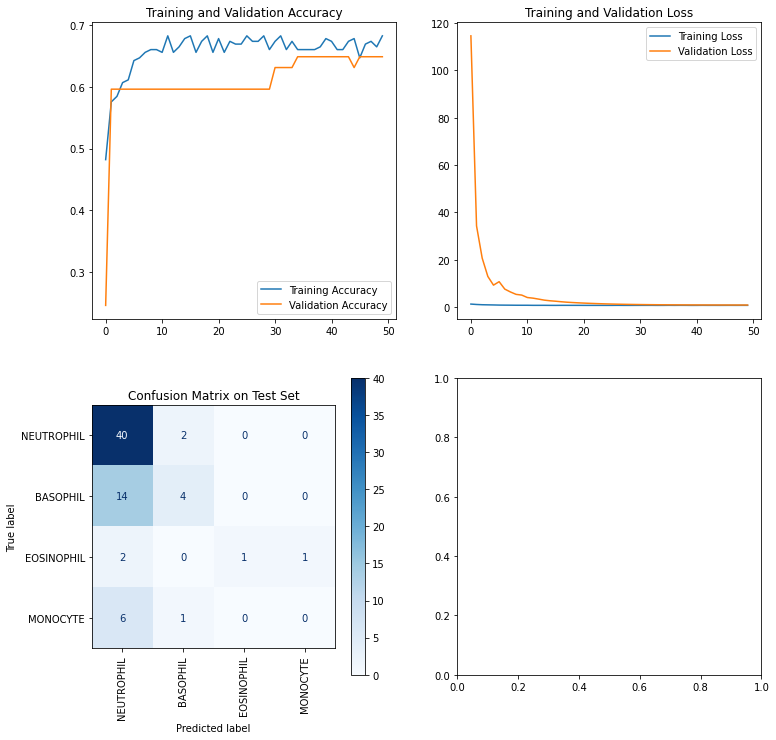

In [ ]:
baseline_model.load_weights(f"models/baseline.hdf5")
evaluate_model(baseline_model, baseline_history, baseline_test)

Almost every cell is labelled as a neutrophil as the dataset is imbalanced

# Balancing the Dataset

In [ ]:
import random

def balance_dataset(dataset, ratio):
    data, targets = [np.array(a) for a in zip(*dataset)]
    class_count = [np.count_nonzero(targets == l) for l in range(len(CLASS_LABELS))]
    largest = np.max(class_count)

    indices = []
    for l, count in zip(range(len(CLASS_LABELS)), class_count):
        class_indices = np.where(targets == l)[0]
        indices += list(
            random.choices(class_indices, k=int(np.round(largest * ratio)))
            if count < largest * ratio
            else class_indices
        )

    return tf.data.Dataset.from_tensor_slices(
        (
            data[indices],
            targets[indices],
        )
    )

Dataset is balanced by oversampling of underrepresented classes.

# Creating a New Model

In [ ]:
balanced_model = create_model(blocks=[1, 2])
balanced_train = balance_dataset(baseline_train, ratio=1)
compile_model(balanced_model, balanced_train)

# Training the New Model

In [ ]:
balanced_history = fit_model(
    balanced_model,
    train_dataset=balanced_train,
    val_dataset=baseline_val,
    epochs=50,
    log_each=10,
    model_name="balanced",
    early_stop=None
)

Epoch: 0, loss: 1.2517143487930298, acc: 0.4824427366256714, val loss: 1349.6419677734375, val accuracy: 0.017543859779834747
Epoch: 10, loss: 0.3258577287197113, acc: 0.8900763392448425, val loss: 35.60919189453125, val accuracy: 0.017543859779834747
Epoch: 20, loss: 0.11937132477760315, acc: 0.9664121866226196, val loss: 3.567796230316162, val accuracy: 0.2982456088066101
Epoch: 30, loss: 0.07798855751752853, acc: 0.9832060933113098, val loss: 1.9632951021194458, val accuracy: 0.5438596606254578
Epoch: 40, loss: 0.09187103807926178, acc: 0.9770992398262024, val loss: 0.9431062936782837, val accuracy: 0.7368420958518982


# Evaluating the New Model

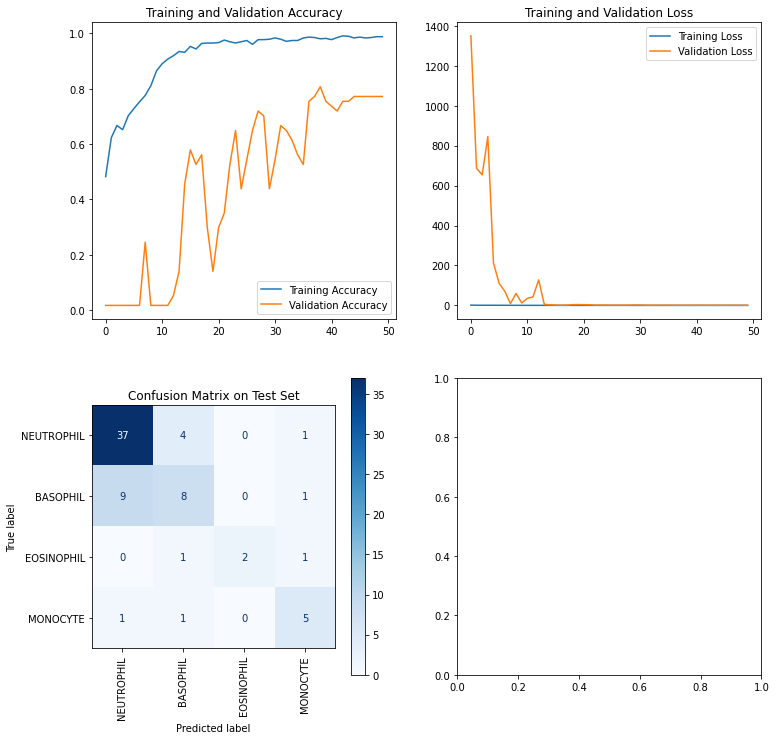

In [ ]:
evaluate_model(balanced_model, balanced_history, baseline_test)

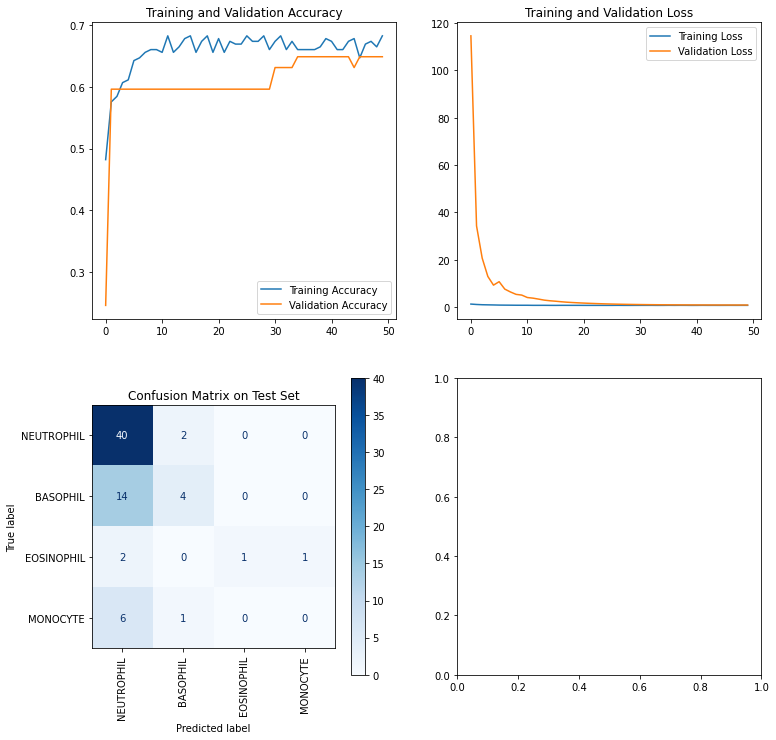

In [ ]:
evaluate_model(baseline_model, baseline_history, baseline_test)